# Initialization


In [95]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from soliket import BinnedClusterLikelihood
from cobaya.model import get_model
import camb
%pylab inline

path2data = '/Users/boris/Work/CLASS-SZ/SO-SZ/SOLikeT/soliket/clusters/data/advact/'

rad_in_deg2 = (np.deg2rad(1.))**2.
from astropy.io import fits
import os, sys

import healpy as hp
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

Populating the interactive namespace from numpy and matplotlib


this cell just tests camb

In [2]:
params = {
    'cosmomc_theta': 0.0104135,
    'ns': 0.965,
    'ombh2': 0.0226576,      
    'omch2': 0.1206864, 
    'As': 2.022662e-9,
    'tenToA0': 4.35e-5,
    'B0': 0.08,
    'scatter_sz': 0.,
    'bias_sz': 1.,
    'tau': 0.055,
    'mnu': 0.0,
    'nnu': 3.046,
    'omnuh2': 0.,
    'w': -1,
    
    'C0': 0. # not used

}

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(cosmomc_theta=params['cosmomc_theta'], ombh2=params['ombh2'], omch2=params['omch2'], mnu=0.0, omk=0, \
                   tau=params['tau'])
pars.InitPower.set_params(As=params['As'], ns=params['ns'], r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2.0)

#Linear spectra
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())
print(s8)

[0.81050087]


# CCL

In [4]:
params = {
    'h': 0.68,
    'n_s': 0.965,
    'Omega_b': 0.049,      
    'Omega_c': 0.26, 
    'sigma8': 0.81,
    'tenToA0': 4.35e-5,
    'B0': 0.08,
    'scatter_sz': 0.,
    'bias_sz': 1.,
    'm_nu': 0.0,
    'C0': 0. # doesnt matter

}


info = {
    'params': params,
    'likelihood': {'soliket.BinnedClusterLikelihood': {
    'verbose': True,
    'data': {
        'data_path': path2data,
        'cat_file': "DR5_cluster-catalog_v1.1.fits",
        'Q_file': "DR5ClusterSearch/selFn/QFit.fits",
        'tile_file': "DR5ClusterSearch/selFn/tileAreas.txt",
        'rms_file': "DR5ClusterSearch/selFn/RMSTab.fits"
    },
    'theorypred': {
        'choose_theory': "CCL",
        'massfunc_mode': 'ccl',
        'choose_dim': "2D",
        'compl_mode': 'erf_diff',
        'md_hmf': '200m',
        'md_ym': '500c',
        'use_class_sz':False
        
    },
    'YM': {
        'Mpivot': 3e14
    },
    'selfunc': {
        'SNRcut': 6.,
        'single_tile_test': "no",
        'mode': 'downsample',
        'dwnsmpl_bins': 5,
        'save_dwsmpld': True,
        'average_Q': False
    },
    'binning': {
        'z': {
            # redshift setting
            'zmin': 0.,
            'zmax': 2.9,
            'dz': 0.1
        },
        'q': {
            # SNR setting
            'log10qmin': 0.6,
            'log10qmax': 2.0,
            'dlog10q': 0.25
        },
        'M': {
            # mass setting
            'Mmin': 1e13,
            'Mmax': 5e15,
            'dlogM': 0.05
        }
    }
    }},
    'theory': {'soliket.clusters.CCL': 
               {'transfer_function': 'boltzmann_camb',
                'matter_pk': 'halofit',
                'baryons_pk': 'nobaryons',
                'md_hmf': '200m'}}
}


# initialisation 
model = get_model(info)
like = model.likelihood['soliket.BinnedClusterLikelihood']

model.loglikes({})[0]

Initializing clusters.py (binned)
Initializing clusters.py (binned)
Downsampling selection function inputs.
Downsampling selection function inputs.
Considering full map.
Considering full map.
2D likelihood as a function of redshift and signal-to-noise.
2D likelihood as a function of redshift and signal-to-noise.
Reading data catalog.
Reading data catalog.
Total number of clusters in catalogue = 4195.
Total number of clusters in catalogue = 4195.
SNR cut = 6.0.
SNR cut = 6.0.
Number of clusters above the SNR cut = 1359.
Number of clusters above the SNR cut = 1359.
The highest redshift = 1.4888
The highest redshift = 1.4888
Number of redshift bins = 29.
Number of redshift bins = 29.
Number of mass bins for theory calculation 124.
Number of mass bins for theory calculation 124.
The lowest SNR = 6.000110771655564.
The lowest SNR = 6.000110771655564.
The highest SNR = 53.52369867212418.
The highest SNR = 53.52369867212418.
Number of SNR bins = 6.
Number of SNR bins = 6.
Edges of SNR bins = 

 ::: 2D ln likelihood =  2039.3064302743674


array([-2039.30643027])

In [4]:
pk_intp = like.theory.get_Pk_interpolator(("delta_nonu", "delta_nonu"), nonlinear=False)
SZparams = {
    'tenToA0': 4.35e-5,
    'B0': 0.08,
    'C0': 0.,
    'scatter_sz': 0.,
    'bias_sz': 1.  
}

In [5]:
Nzq = like._get_theory(pk_intp, **SZparams)
z, q, catNzq = like.delN2Dcat

Nq_ccl = np.zeros(len(q))
catNq_ccl = np.zeros(len(q))
for i in range(len(q)):
    Nq_ccl[i] = Nzq[:,i].sum()    
    catNq_ccl[i] = catNzq[:,i].sum()

y0 needed: [[[1.31646059e-06 1.39107737e-06 1.46956821e-06 ... 2.79190611e-04
   2.90158850e-04 3.01557973e-04]
  [1.28904146e-06 1.36550751e-06 1.44615657e-06 ... 3.27470451e-04
   3.40325225e-04 3.53675111e-04]
  [1.24424299e-06 1.32080921e-06 1.40174837e-06 ... 3.74858104e-04
   3.89651924e-04 4.05011132e-04]
  ...
  [4.62089413e-07 5.05810548e-07 5.53553918e-07 ... 6.88527155e-03
   7.37201726e-03 7.89152286e-03]
  [4.66752897e-07 5.10967957e-07 5.59255890e-07 ... 7.03030876e-03
   7.52811328e-03 8.05948796e-03]
  [4.71429035e-07 5.16139101e-07 5.64972780e-07 ... 7.17628523e-03
   7.68522978e-03 8.22856105e-03]]

 [[1.35579262e-06 1.43360479e-06 1.51551569e-06 ... 3.01072099e-04
   3.12893810e-04 3.25177642e-04]
  [1.31817960e-06 1.39731451e-06 1.48083979e-06 ... 3.53060309e-04
   3.66938707e-04 3.81350024e-04]
  [1.26491786e-06 1.34364644e-06 1.42693250e-06 ... 4.03839256e-04
   4.19824279e-04 4.36419286e-04]
  ...
  [5.62333506e-07 6.10630367e-07 6.63117688e-07 ... 6.82280082e-03

IndexError: index 5 is out of bounds for axis 0 with size 5

Number of clusters in snr bin 0: 4813.890684491792.
Number of clusters in snr bin 1: 2623.9866343534754.
Number of clusters in snr bin 2: 522.5901796118821.
Number of clusters in snr bin 3: 71.8898301206965.
Number of clusters in snr bin 4: 5.65663339935425.
Number of clusters in snr bin 5: 0.196660238633574.
Total predicted 2D N = 8038.210622215834.
Theory N calculation took 41.82662105560303 seconds.

[]

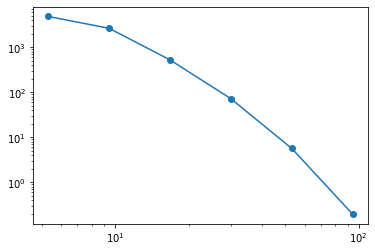

In [6]:
plt.plot(q,Nq_ccl,marker='o')
plt.loglog()

In [7]:
Nz_ccl = np.zeros(len(z))
catNz_ccl = np.zeros(len(z))
for i in range(len(z)):
    Nz_ccl[i] = Nzq[i,:].sum()    
    catNz_ccl[i] = catNzq[i,:].sum()

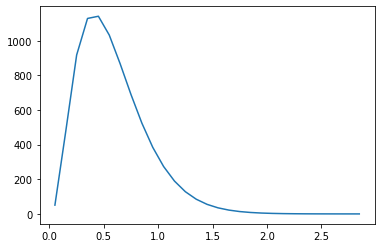

In [9]:
plt.plot(z,Nz_ccl)

# CAMB

In [10]:
params = {
    'cosmomc_theta': 0.0104135,
    'ns': 0.965,
    'ombh2': 0.0226576,      
    'omch2': 0.1206864, 
    'As': 2.022662e-9,
    'tenToA0': 4.35e-5,
    'B0': 0.08,
    'scatter_sz': 0.,
    'bias_sz': 1.,
    'tau': 0.055,
    'mnu': 0.0,
    'nnu': 3.046,
    'omnuh2': 0.,
    'w': -1,
    
    'C0': 0.

}


info = {
    'params': params,
    'likelihood': {'soliket.BinnedClusterLikelihood': {
    'verbose': False,
    'data': {
        'data_path': path2data,
        'cat_file': "DR5_cluster-catalog_v1.1.fits",
        'Q_file': "DR5ClusterSearch/selFn/QFit.fits",
        'tile_file': "DR5ClusterSearch/selFn/tileAreas.txt",
        'rms_file': "DR5ClusterSearch/selFn/RMSTab.fits"
    },
    'theorypred': {
        'choose_theory': "camb",
        'massfunc_mode': 'internal',
        'choose_dim': "2D",
        'compl_mode': 'erf_diff',
        'md_hmf': '200m',
        'md_ym': '500c',
        'use_class_sz' : False
        
    },
    'YM': {
        'Mpivot': 3e14
    },
    'selfunc': {
        'SNRcut': 5.,
        'single_tile_test': "no",
        'mode': 'downsample',
        'dwnsmpl_bins': 5,
        'average_Q': False,
        'save_dwsmpld': True,
    },
    'binning': {
        'z': {
            # redshift setting
            'zmin': 0.,
            'zmax': 2.9,
            'dz': 0.1
        },
        'q': {
            # SNR setting
            'log10qmin': 0.6,
            'log10qmax': 2.0,
            'dlog10q': 0.25
        },
        'M': {
            # mass setting
            'Mmin': 1e13,
            'Mmax': 5e15,
            'dlogM': 0.05
        }
    }
    }},
    'theory': {'camb': {'extra_args': {'num_massive_neutrinos': 0}}}
}


# initialisation 
model = get_model(info)
like = model.likelihood['soliket.BinnedClusterLikelihood']

model.loglikes({})[0]

[camb] `camb` module loaded successfully from /usr/local/anaconda3/envs/cluster_counts_environment/lib/python3.8/site-packages/camb
qbins: [0.725 0.975 1.225 1.475 1.725 1.975]
zbin: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85]
 Nz for higher resolution =  70
 ::: 2D ln likelihood =  8025.043492369844


array([-8025.04349237])

In [11]:
pk_intp = like.theory.get_Pk_interpolator(("delta_nonu", "delta_nonu"), nonlinear=False)
SZparams = {
    'tenToA0': 4.35e-5,
    'B0': 0.08,
    'C0': 0.,
    'scatter_sz': 0.,
    'bias_sz': 1.  
}

In [12]:
Nzq = like._get_theory(pk_intp, **SZparams)
z, q, catNzq = like.delN2Dcat

In [13]:
Nq = np.zeros(len(q))
catNq = np.zeros(len(q))
for i in range(len(q)):
    Nq[i] = Nzq[:,i].sum()    
    catNq[i] = catNzq[:,i].sum()
Nz = np.zeros(len(z))
catNz = np.zeros(len(z))
for i in range(len(z)):
    Nz[i] = Nzq[i,:].sum()    
    catNz[i] = catNzq[i,:].sum()

In [14]:
color_list = plt.cm.magma(np.linspace(0.1,0.8,13))

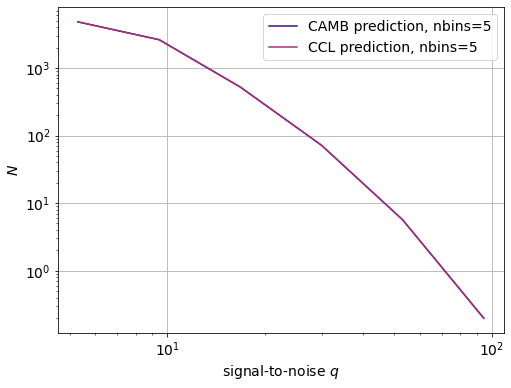

In [16]:
plt.figure(figsize=(8,6))
plt.plot(q, Nq, color=color_list[2], label='CAMB prediction, nbins=5')
plt.plot(q, Nq_ccl, color=color_list[6], label='CCL prediction, nbins=5')
# plt.errorbar(q, catNq, yerr=np.sqrt(catNq), color='black', fmt='o', ms=3, capsize=5, capthick=2, ls='none', label='mock catalogue')
plt.xlabel('signal-to-noise $q$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

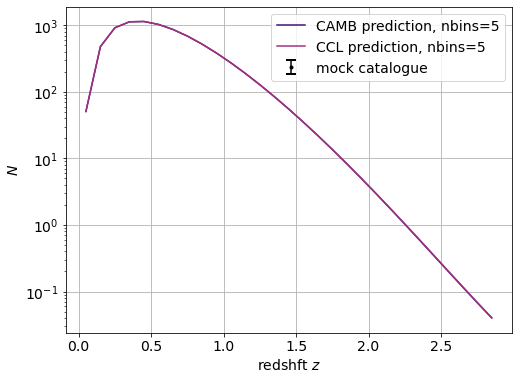

In [17]:
plt.figure(figsize=(8,6))
plt.plot(z, Nz, color=color_list[2], label='CAMB prediction, nbins=5')
plt.plot(z, Nz_ccl, color=color_list[6], label='CCL prediction, nbins=5')
plt.errorbar(z, catNz, yerr=np.sqrt(catNz), color='black', fmt='o', ms=3, capsize=5, capthick=2, ls='none', label='mock catalogue')
plt.xlabel('redshft $z$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
plt.xscale('linear')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

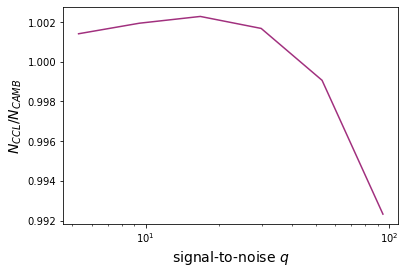

In [18]:
plt.semilogx(q, Nq_ccl/Nq, color=color_list[6])
plt.xlabel('signal-to-noise $q$', fontsize=14)
plt.ylabel('$N_{CCL}/N_{CAMB}$', fontsize=14)
plt.show()

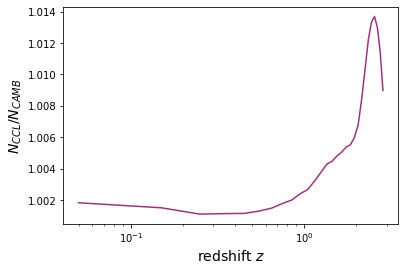

In [19]:
plt.semilogx(z, Nz_ccl/Nz, color=color_list[6])
plt.xlabel('redshift $z$', fontsize=14)
plt.ylabel('$N_{CCL}/N_{CAMB}$', fontsize=14)
plt.show()

useful block to save for class_sz format

In [12]:

datafile_Q_dwsmpld = '/Users/boris/Work/CLASS-SZ/SO-SZ/SOLikeT/soliket/binned_clusters/data/advact/DR5ClusterSearch/selFn/QFitdwsmpld_nbins=5.npz'
Qfile = np.load(datafile_Q_dwsmpld)
allQ = Qfile['Q_dwsmpld']
tt500 = Qfile['tt500']

datafile_rms_dwsmpld = '/Users/boris/Work/CLASS-SZ/SO-SZ/SOLikeT/soliket/binned_clusters/data/advact/DR5ClusterSearch/selFn/RMSTabdwsmpld_nbins=5..npz'
rms = np.load(datafile_rms_dwsmpld)
noise = rms['noise']
skyfracs = rms['skyfracs']

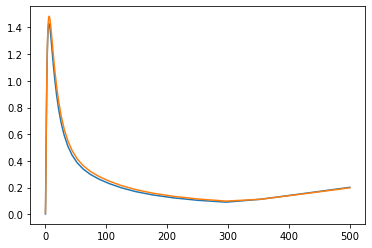

In [13]:
plt.plot(tt500,allQ[:,0])
plt.plot(tt500,allQ[:,1])
plt.show()

In [14]:
np.shape(tt500)
tt500.size

51

In [15]:
noise

array([9.13590715e-06, 1.32191117e-05, 1.73023162e-05, 2.13855207e-05,
       2.54687253e-05])

In [17]:
rad_in_deg2 = (np.deg2rad(1.))**2.
skyfracs/rad_in_deg2/41253.

array([0.0488115 , 0.09714411, 0.10777072, 0.06211241, 0.00441423])

In [9]:
rad_in_deg2 = (np.deg2rad(1.))**2.
datafile_Q_dwsmpld = '/Users/boris/Work/CLASS-SZ/SO-SZ/SOLikeT/soliket/binned_clusters/data/advact/DR5ClusterSearch/selFn/QFitdwsmpld_nbins=1.npz'
Qfile = np.load(datafile_Q_dwsmpld)
allQ = Qfile['Q_dwsmpld']
tt500 = Qfile['tt500']

datafile_rms_dwsmpld = '/Users/boris/Work/CLASS-SZ/SO-SZ/SOLikeT/soliket/binned_clusters/data/advact/DR5ClusterSearch/selFn/RMSTabdwsmpld_nbins=1..npz'
rms = np.load(datafile_rms_dwsmpld)
noise = rms['noise']
skyfracs = rms['skyfracs']

In [ ]:
path_to_save = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/'

In [ ]:
# np.savetxt(path_to_catalogue+'so_3freqs_191121_theta500arcmin_Q.txt',np.c_[tt500,Q])
path_to_save = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/'
np.savetxt(path_to_save+'advact_dr5_skyfracs_300621_1bins.txt',np.c_[skyfracs/rad_in_deg2/41253.])

In [ ]:
so_skyfracs = np.loadtxt(path_to_save+'advact_dr5_skyfracs_300621_1bins.txt')
so_ylims = []
for index_thetas in range(tt500.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/allQ[index_thetas,id_patches])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_save+'advact_dr5_ylims_300621_1bins.txt',np.c_[so_ylims])
np.savetxt(path_to_save+'advact_dr5_thetas_300621_1bins.txt',np.c_[tt500])

# CLASS SZ

In [52]:
class_sz_params = {
'output' : 'sz_cluster_counts',
'mass function'  : 'T08',
'concentration parameter' : 'B13',
'has_selection_function' : 1,
'experiment' : 1.,
#'sky_area_deg2' : 599.353 # not used when completeness demanded
'y_m_relation' : 1,
'use_planck_binned_proba' : 0, #use diff of erfs
'class_sz_verbose'  : 0,

'M_min' : 1e13,
'M_max' : 5e15,
    


'N_ur' : 2.0328,
'N_ncdm' : 1,
'm_ncdm' : 0.0,
'T_ncdm' : 0.71611,

'non linear' : 'halofit',


# scaling law parameter
# Hilton et al 2020
'A_ym'  : 4.35e-5,
'B_ym'  : 0.08,
'm_pivot_ym [Msun]' : 3e14,




'bin_z_min_cluster_counts'  : 0.0,
'bin_z_max_cluster_counts'  : 3.0,
'bin_dz_cluster_counts'  : 0.1,
    
'bin_dlog10_snr' : 0.25,
'log10_snr_min' : 0.6,
'log10_snr_max' : 2.,    
    
    
# 'dlny' : 0.03,
# 'lnymin' : -11.,
# 'lnymax' : -5.,
#sigmaM_ym = 0.075
'sigmaM_ym' : 0.,
'dlnM_cluster_count_completeness_grid' : 0.05,


'cluster_count_completeness_grid_z_cutoff_low' : 0.2,
'cluster_count_completeness_grid_z_cutoff_mid' : 1.,
'dz_cluster_count_completeness_grid_low_z' : 1e-2,
'dz_cluster_count_completeness_grid_mid_z' : 5e-2,
'dz_cluster_count_completeness_grid_high_z' : 5e-2,

'mass_epsrel_cluster_counts' : 1e-5,
'mass_epsabs_cluster_counts' : 1e-50,

'redshift_epsrel_cluster_counts' : 1e-3,
'redshift_epsabs_cluster_counts' : 1e-30,



'signal-to-noise cut-off for survey cluster completeness' : 5,



'100*theta_s': 1.04135,
'n_s': 0.965,
'omega_b': 0.0226576,      
'omega_cdm': 0.1206864, 
'A_s': 2.022662e-9,    
    
# X ray mass bias (if applicable)
'B' : 1.,




# tabulation of mass function:
'n_z_dndlnM' : 100,
'n_m_dndlnM' : 100,

# computation of mass function
# (grid in mass and redshifts for sigma and dsigma)
'ndim_masses' : 100,
'ndim_redshifts' : 100,

# pk setup for computation of sigma and dsigma
'k_per_decade_class_sz' : 20.,
'k_min_for_pk_class_sz' : 1e-3,
'k_max_for_pk_class_sz' : 1e1,
'P_k_max_h/Mpc' : 1e1,

'SO_thetas_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/advact_dr5_thetas_300621.txt',
'SO_skyfracs_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/advact_dr5_skyfracs_300621.txt',
'SO_ylims_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/advact_dr5_ylims_300621.txt'
}


In [53]:
from classy_sz import Class
M = Class()
M.set(class_sz_params)
M.set({
# # 'B_ym': 0.08,
# # 'A_ym': 4.35e-5,
# 'C_ym' : 0.,
# # 'sigmaM_ym' : 0.0,

# 'M_min' : 1e10,
# 'M_max' : 5e15,    
# 'z_min': 1e-5,
# 'z_max':3.,

# 'apply_relativistic_correction_to_y_m':0,
# 'signal-to-noise cut-off for survey cluster completeness' : 5.,
# # 'use_websky_m200m_to_m200c_conversion': 1,

# # 'dlny' : 0.001, #HW used to be 0.01, #step in y integral
# # 'lnymin' : -11., #HW no impact
# # 'lnymax' : 10., #HW no impact

# 'dlnM_cluster_count_completeness_grid' : 0.0005, #HW used to be 0.01, try bigger, big impact on speed


# 'cluster_count_completeness_grid_z_cutoff_low' : 0.5, #HW good value, #integrating over redshift, different regeims
# 'cluster_count_completeness_grid_z_cutoff_mid' : 1.5, #HW no change

# 'dz_cluster_count_completeness_grid_low_z' : 0.01, #HW used to be 0.001
# 'dz_cluster_count_completeness_grid_mid_z' : 0.01, #HW used to be 0.1
# 'dz_cluster_count_completeness_grid_high_z' : 0.01, #HW used to be 1e-1, #try taking bigger steps

# 'mass_epsrel_cluster_counts' : 1e-5, #leave as is
# 'mass_epsabs_cluster_counts' : 1e-50,

# 'redshift_epsrel_cluster_counts' : 1e-3, #leave as is
# 'redshift_epsabs_cluster_counts' : 1e-30,

# # # tabulation of mass function:
# 'n_z_dndlnM' : 150, #HW previously 150
# 'n_m_dndlnM' : 200, #HW previously 150

# # # computation of mass function
# # # (grid in mass and redshifts for sigma and dsigma)
#     #HW these are extremely high, try 80 or 100
# 'ndim_masses' : 250, #HW previoulsy 250, big impact on speed
# 'ndim_redshifts' : 80, #HW previously 250, big impact on speed

# # pk setup for computation of sigma and dsigma
# 'k_per_decade_class_sz' : 100., #HW previously 20, last one I can change
# 'k_min_for_pk_class_sz' : 1e-3, #Don't change below this
# 'k_max_for_pk_class_sz' : 1e1,

# 'P_k_max_h/Mpc' : 1e1,
# 'non linear': 'halofit',

# 'm_pivot_ym [Msun]' : 3e14,   
})
M.compute()

In [54]:
print('h : %f'%M.h())
print('sigma8 : %f'%M.sigma8())
print('Omega_m : %f'%M.Omega_m())
print('n_s : %f'%M.n_s())

h : 0.677322
sigma8 : 0.809357
Omega_m : 0.312457
n_s : 0.965000


In [55]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']

In [56]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_with_rel = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz][:-1]))
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))



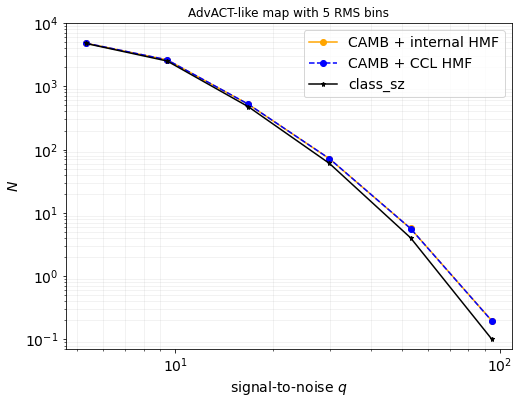

In [62]:
plt.figure(figsize=(8,6))
plt.plot(q, Nq, color='orange',marker='o', label='CAMB + internal HMF')
plt.plot(q, Nq_ccl, color='blue',ls='--', label='CAMB + CCL HMF',marker='o')
# plt.errorbar(q, catNq, yerr=np.sqrt(catNq), color='black', fmt='o', ms=3, capsize=5, capthick=2, ls='none', label='mock catalogue')
# plt.errorbar(10**np.asarray(log10y_center),N_clusters_y_theory,
#              yerr=np.sqrt(N_clusters_y_theory),
#              marker='o',markersize=3.,ls='none',label='class_sz',capsize=9,c='orange')
plt.plot(10**np.asarray(log10y_center[:-1]),N_clusters_y_theory[:-1],
             marker='*',markersize=5.,ls='-',label='class_sz',c='k')

plt.ylim(7e-2,1e4)
plt.xlabel('signal-to-noise $q$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(which = 'both',alpha = 0.2)
plt.title('AdvACT-like map with 5 RMS bins')
plt.grid()
plt.show()

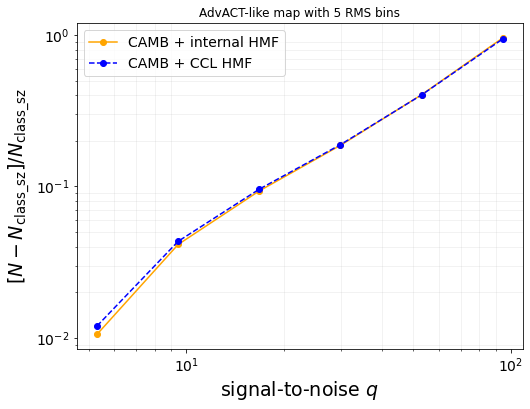

In [75]:
plt.figure(figsize=(8,6))
plt.plot(q, (Nq-N_clusters_y_theory[:-1])/N_clusters_y_theory[:-1], color='orange',marker='o', label='CAMB + internal HMF')
plt.plot(q, (Nq_ccl-N_clusters_y_theory[:-1])/N_clusters_y_theory[:-1], color='blue',ls='--', label='CAMB + CCL HMF',marker='o')
# plt.errorbar(q, catNq, yerr=np.sqrt(catNq), color='black', fmt='o', ms=3, capsize=5, capthick=2, ls='none', label='mock catalogue')
# plt.errorbar(10**np.asarray(log10y_center),N_clusters_y_theory,
#              yerr=np.sqrt(N_clusters_y_theory),
#              marker='o',markersize=3.,ls='none',label='class_sz',capsize=9,c='orange')
# plt.plot(10**np.asarray(log10y_center[:-1]),N_clusters_y_theory[:-1],

#              marker='*',markersize=5.,ls='-',label='class_sz',c='k')

# plt.ylim(7e-2,1e4)
plt.xlabel('signal-to-noise $q$', fontsize=19)
plt.ylabel('$[N-N_\mathrm{class\_sz}]/N_\mathrm{class\_sz}$', fontsize=19)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(which = 'both',alpha = 0.2)
plt.title('AdvACT-like map with 5 RMS bins')
plt.grid()
plt.show()

In [63]:
log10y_center

[0.725, 0.975, 1.225, 1.475, 1.725, 1.975, inf]

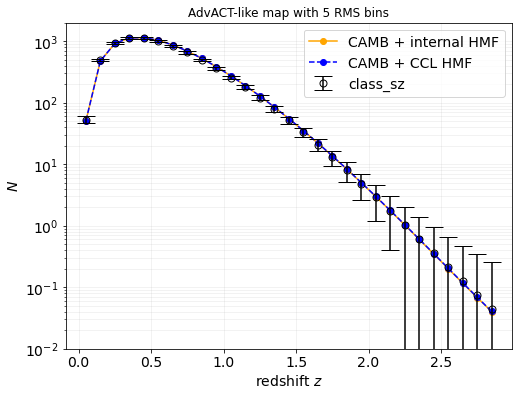

In [61]:
plt.figure(figsize=(8,6))
plt.plot(z, Nz, color='orange', label='CAMB + internal HMF',marker='o')
plt.plot(z, Nz_ccl, color='blue',ls='--', label='CAMB + CCL HMF',marker='o')
# plt.errorbar(z, catNz, yerr=np.sqrt(catNz), color='black', fmt='o', ms=3, capsize=5, capthick=2, ls='none', label='mock catalogue')
plt.errorbar(z_center,N_clusters_z_theory,yerr=np.sqrt(N_clusters_z_theory),marker='o',markersize=7.,ls='none',
             label='class_sz',capsize=9,
             markerfacecolor='none',
             c='k')


plt.xlabel('redshift $z$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
plt.xscale('linear')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(1e-2,2e3)
plt.grid(which = 'both',alpha = 0.2)
plt.title('AdvACT-like map with 5 RMS bins')
plt.show()


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(z, (Nz-N_clusters_z_theory)/N_clusters_z_theory, color='orange', label='CAMB + internal HMF',marker='o')
plt.plot(z, (Nz_ccl-N_clusters_z_theory)/N_clusters_z_theory, color='blue',ls='--', label='CAMB + CCL HMF',marker='o')
# plt.errorbar(z, catNz, yerr=np.sqrt(catNz), color='black', fmt='o', ms=3, capsize=5, capthick=2, ls='none', label='mock catalogue')
# plt.errorbar(z_center,N_clusters_z_theory,yerr=np.sqrt(N_clusters_z_theory),marker='o',markersize=7.,ls='none',
#              label='class_sz',capsize=9,
#              markerfacecolor='none',
#              c='k')


plt.xlabel('redshift $z$', fontsize=14)
plt.ylabel('$[N-N_\mathrm{class\_sz}]/N_\mathrm{class\_sz}$', fontsize=19)
plt.xscale('linear')
plt.yscale('linear')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.ylim(1e-2,2e3)
plt.grid(which = 'both',alpha = 0.2)
plt.title('AdvACT-like map with 5 RMS bins')
plt.show()


# NEMO

Need ~50 rms bins

In [22]:
path2_sim_data = path2data+'DR5CosmoSims/sim-kit_NemoCCL_A10tSZ_DR5White_ACT-DR5_tenToA0Tuned/'\
'NemoCCL_A10tSZ_DR5White_ACT-DR5_tenToA0Tuned/'

In [2]:
import nemo_mocks
import imp
imp.reload(nemo_mocks)

<module 'nemo_mocks' from '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/notebooks/nemo_mocks.py'>

In [3]:




mockconfig = {
    'predSNRCut': 5,
    'path2truthcat': path2_sim_data+'../NemoCCL_A10tSZ_DR5White_ACT-DR5_tenToA0Tuned_truthCatalog.fits',
    'path2noisemap': path2_sim_data+'selFn/stitched_RMSMap_Arnaud_M2e14_z0p4.fits',
    'path2selFn': path2_sim_data+'selFn',
    'path2Qfunc': path2_sim_data+'selFn/QFit.fits',
    'relativisticCorrection': False,
    'rhoType': 'critical',
    'massFunc': 'Tinker08',
    'delta': 200,
    'applyPoissonScatter': False,
    'predAreaScale': 1.000, 
    'makeMock': True,
    'selFnZStep': 0.01
}


In [4]:
# Make a 'true' mock - use the truth catalog, get true_SNR by looking up noise in the selFn dir
mode = 'without_Q'
truthTab = nemo_mocks.make_truth_mock(mode, mockconfig)

In [31]:
h = 0.68

params = {
    'h': 0.68,
    'n_s': 0.965,
    'Omega_b': 0.049,      
    'Omega_c': 0.26, 
    'sigma8': 0.81,
    'tenToA0': 1.9e-05,
    'B0': 0.08,
    'scatter_sz': 0.,
    'bias_sz': 1.,
    'm_nu': 0.0,
    'C0': 0.

}




info = {
    'params': params,
    'likelihood': {'soliket.BinnedClusterLikelihood': {
    'verbose': True,
    'data': {
        'data_path': path2_sim_data,
        'cat_file': 'NemoCCL_A10tSZ_DR5White_ACT-DR5_tenToA0Tuned_mass.fits',
        'Q_file': "selFn/QFit.fits",
        'tile_file': "selFn/tileAreas.txt",
        'rms_file': "selFn/RMSTab.fits"
        
#         'data_path': path2data,
#         'cat_file': "DR5_cluster-catalog_v1.1.fits",
#         'Q_file': "DR5ClusterSearch/selFn/QFit.fits",
#         'tile_file': "DR5ClusterSearch/selFn/tileAreas.txt",
#         'rms_file': "DR5ClusterSearch/selFn/RMSTab.fits"        
        
    },
    'theorypred': {
        'choose_theory': "CCL",
        'massfunc_mode': 'ccl',
        'choose_dim': "2D",
        'compl_mode': 'erf_diff',
        'md_hmf': '200c',
        'md_ym': '200c',
        'use_class_sz':False
        
    },
    'YM': {
        'Mpivot': 4.25e14 # andrina has 4.25e14*0.68 but should be in Msun (in boris's version)
    },
    'selfunc': {
        'SNRcut': 5.,
        'single_tile_test': "no",
        'mode': 'downsample',
        'dwnsmpl_bins': 50,
        'save_dwsmpld': True,
        'average_Q': False
    },
    'binning': {
        'z': {
            # redshift setting
            'zmin': 0.,
            'zmax': 2.8,
            'dz': 0.1
        },
        'q': {
            # SNR setting
            'log10qmin': 0.6,
            'log10qmax': 2.0,
            'dlog10q': 0.25
        },
        'M': {
            # mass setting
            'Mmin': 5e13*0.68,
            'Mmax': 1e16*0.68,
            'dlogM': 0.05
        }
    }
    }},
    'theory': {'soliket.binned_clusters.CCL': 
               {'transfer_function': 'boltzmann_camb',
                'matter_pk': 'halofit',
                'baryons_pk': 'nobaryons',
                'md_hmf': '200c'}}
}

# initialisation 
model = get_model(info)
like = model.likelihood['soliket.BinnedClusterLikelihood']
model.loglikes({})[0]

Initializing binned_clusters_test.py
Downsampling selection function inputs.
Considering full map.
2D likelihood as a function of redshift and signal-to-noise.
Reading data catalog.
Total number of clusters in catalogue = 6522.
SNR cut = 5.0.
Number of clusters above the SNR cut = 2479.
The highest redshift = 1.935
Number of redshift bins = 28.
Number of mass bins for theory calculation 106.
The lowest SNR = 5.003420154903202.
The highest SNR = 43.010754788401286.
Number of SNR bins = 6.
Edges of SNR bins = [0.6  0.85 1.1  1.35 1.6  1.85 2.1 ].
Loading files describing selection function.
Reading Q as a function of theta.
Reading in binned Q function from file.
Reading RMS.
Reading in binned RMS table from file.
Number of rms bins = 50.
Number of Q functions = 50.
Entire survey area = 13631.392731778147 deg2.


 Nz for higher resolution =  68


 Total predicted 2D N = 2756.814306628537
Number of clusters in redshift bin 0: 63.82210082507393.
Number of clusters in redshift bin 1: 281.6298540905071.
Number of clusters in redshift bin 2: 395.7666329491798.
Number of clusters in redshift bin 3: 417.8967130508216.
Number of clusters in redshift bin 4: 382.38421385546644.
Number of clusters in redshift bin 5: 321.7071887855182.
Number of clusters in redshift bin 6: 255.28949054053018.
Number of clusters in redshift bin 7: 193.1130818944539.
Number of clusters in redshift bin 8: 140.9623427503703.
Number of clusters in redshift bin 9: 100.00702104843363.
Number of clusters in redshift bin 10: 69.27343393630217.
Number of clusters in redshift bin 11: 47.02294293588626.
Number of clusters in redshift bin 12: 31.363894816780302.
Number of clusters in redshift bin 13: 20.593854197311313.
Number of clusters in redshift bin 14: 13.334995374510724.
Number of clusters in redshift bin 15: 8.529417632173919.
Number of clusters in redshift bin

 ::: 2D ln likelihood =  230.7458175398654


array([-230.74581754])

In [6]:
pk_intp = like.theory.get_Pk_interpolator(("delta_nonu", "delta_nonu"), nonlinear=False)
SZparams = {
    'tenToA0': 1.9e-05,
    'B0': 0.08,
    'C0': 0.,
    'scatter_sz': 0.,
    'bias_sz': 1.  
}

In [7]:
Nzq = like._get_theory(pk_intp, **SZparams)
z, q, catNzq = like.delN2Dcat

Nq = np.zeros(len(q))
catNq = np.zeros(len(q))
for i in range(len(q)):
    Nq[i] = Nzq[:,i].sum()    
    catNq[i] = catNzq[:,i].sum()

 Total predicted 2D N = 2756.814306628537
Number of clusters in redshift bin 0: 63.82210082507393.
Number of clusters in redshift bin 1: 281.6298540905071.
Number of clusters in redshift bin 2: 395.7666329491798.
Number of clusters in redshift bin 3: 417.8967130508216.
Number of clusters in redshift bin 4: 382.38421385546644.
Number of clusters in redshift bin 5: 321.7071887855182.
Number of clusters in redshift bin 6: 255.28949054053018.
Number of clusters in redshift bin 7: 193.1130818944539.
Number of clusters in redshift bin 8: 140.9623427503703.
Number of clusters in redshift bin 9: 100.00702104843363.
Number of clusters in redshift bin 10: 69.27343393630217.
Number of clusters in redshift bin 11: 47.02294293588626.
Number of clusters in redshift bin 12: 31.363894816780302.
Number of clusters in redshift bin 13: 20.593854197311313.
Number of clusters in redshift bin 14: 13.334995374510724.
Number of clusters in redshift bin 15: 8.529417632173919.
Number of clusters in redshift bin

In [8]:
Nz = np.zeros(len(z))
catNz = np.zeros(len(z))
for i in range(len(z)):
    Nz[i] = Nzq[i, :].sum()    
    catNz[i] = catNzq[i, :].sum()

In [9]:
bin_params = info['likelihood']['soliket.BinnedClusterLikelihood']['binning']


zbins = np.arange(bin_params['z']['zmin'], bin_params['z']['zmax'] + bin_params['z']['dz'], \
                  bin_params['z']['dz'])

logqmin = bin_params['q']['log10qmin']
logqmax = bin_params['q']['log10qmax']
dlogq = bin_params['q']['dlog10q']


qbins = 10**np.arange(logqmin, logqmax+dlogq, dlogq)
qbins

array([  3.98107171,   7.07945784,  12.58925412,  22.38721139,
        39.81071706,  70.79457844, 125.89254118])

In [10]:
truth_cat, zarr, qarr = nemo_mocks.bin_catalog(truthTab[truthTab['true_SNR']>5], zbins, qbins, SNR_tag='true_SNR')

In [11]:
mockTab = nemo_mocks.make_nemo_mock(mockconfig)

In [12]:
mock_cat, zarr, qarr = nemo_mocks.bin_catalog(mockTab[mockTab['fixed_SNR']>5], zbins, qbins, SNR_tag='fixed_SNR')

In [13]:
Nq_truth = np.zeros(len(q))

for i in range(len(q)):
    Nq_truth[i] = truth_cat[:,i].sum()  

In [14]:
Nz_truth = np.zeros(len(z))

for i in range(len(z)):
    Nz_truth[i] = truth_cat[i,:].sum() 

In [15]:
Nq_mock = np.zeros(len(q))

for i in range(len(q)):
    Nq_mock[i] = mock_cat[:,i].sum() 

In [16]:
Nz_mock = np.zeros(len(z))

for i in range(len(z)):
    Nz_mock[i] = mock_cat[i,:].sum() 

In [17]:
color_list = plt.cm.magma(np.linspace(0.1,0.8,13))

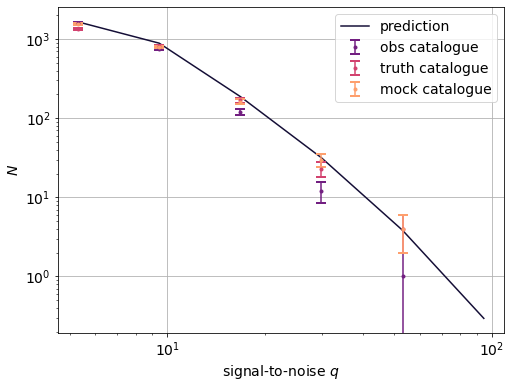

In [18]:
plt.figure(figsize=(8,6))
plt.plot(q, Nq, color=color_list[0], label='prediction')
plt.errorbar(q, catNq, yerr=np.sqrt(catNq), color=color_list[4], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='obs catalogue')
plt.errorbar(q, Nq_truth, yerr=np.sqrt(Nq_truth), color=color_list[8], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='truth catalogue')
plt.errorbar(q, Nq_mock, yerr=np.sqrt(Nq_mock), color=color_list[12], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='mock catalogue')
plt.xlabel('signal-to-noise $q$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
# plt.title('WebSkyHalos A10tSZ cat comparison', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [25]:
predNz = nemo_mocks.get_nemo_pred(mockconfig , zbins)

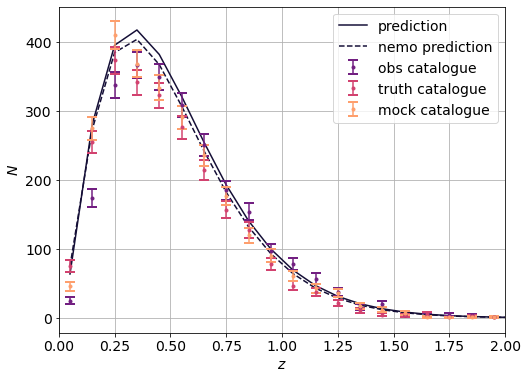

In [26]:
plt.figure(figsize=(8,6))
plt.plot(z, Nz, color=color_list[0], label='prediction')
plt.plot(z, predNz, color=color_list[0], linestyle='--', label='nemo prediction')
plt.errorbar(z, catNz, yerr=np.sqrt(catNz), color=color_list[4], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='obs catalogue')
plt.errorbar(z, Nz_truth, yerr=np.sqrt(Nz_truth), color=color_list[8], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='truth catalogue')
plt.errorbar(z, Nz_mock, yerr=np.sqrt(Nz_mock), color=color_list[12], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='mock catalogue')
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
# plt.title('WebSkyHalos A10tSZ cat comparison', fontsize=14)
plt.xlim(0, 2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [27]:
np.savetxt(path2_sim_data+'n_of_z_030722_z_ccl_nemo_obs_truth_mock.txt',np.c_[z,Nz,predNz,catNz,Nz_truth,Nz_mock])

In [29]:
np.savetxt(path2_sim_data+'n_of_q_030722_q_ccl_obs_truth_mock.txt',np.c_[q,Nq,catNq,Nq_truth,Nq_mock])

Save the files for class_sz

In [21]:
rad_in_deg2 = (np.deg2rad(1.))**2.
datafile_Q_dwsmpld = path2_sim_data+'selFn/QFitdwsmpld_nbins=50.npz'
Qfile = np.load(datafile_Q_dwsmpld)
allQ = Qfile['Q_dwsmpld']
tt500 = Qfile['tt500']

datafile_rms_dwsmpld = path2_sim_data+'selFn/RMSTabdwsmpld_nbins=50..npz'
rms = np.load(datafile_rms_dwsmpld)
noise = rms['noise']
skyfracs = rms['skyfracs']

In [22]:
# np.savetxt(path_to_catalogue+'so_3freqs_191121_theta500arcmin_Q.txt',np.c_[tt500,Q])
path_to_save = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/'
np.savetxt(path_to_save+'nemo_sims_skyfracs_030722_50bins.txt',np.c_[skyfracs/rad_in_deg2/41253.])

In [24]:
so_skyfracs = np.loadtxt(path_to_save+'nemo_sims_skyfracs_030722_50bins.txt')
so_ylims = []
for index_thetas in range(tt500.size):
    for id_patches in range(so_skyfracs.size):
        so_ylims.append(noise[id_patches]/allQ[index_thetas,id_patches])
so_ylims = np.asarray(so_ylims)
np.savetxt(path_to_save+'nemo_sim_ylims_030722_50bins.txt',np.c_[so_ylims])
np.savetxt(path_to_save+'nemo_sim_thetas_030722_50bins.txt',np.c_[tt500])

In [15]:
class_sz_params = {
'output' : 'sz_cluster_counts',
'mass function'  : 'T08M200c',
'concentration parameter' : 'B13',
'has_selection_function' : 1,
'experiment' : 1.,
#'sky_area_deg2' : 599.353 # not used when completeness demanded
'y_m_relation' : 1,
'use_planck_binned_proba' : 0, #use diff of erfs
'class_sz_verbose'  : 0,


'M_min': 5e13*0.68,
'M_max': 1e16*0.68,



'N_ur' : 2.0328,
'N_ncdm' : 1,
'm_ncdm' : 0.0,
'T_ncdm' : 0.71611,

'non linear' : 'halofit',


# scaling law parameter
# Hilton et al 2020
'A_ym'  : 1.9e-05,
'B_ym'  : 0.08,
'm_pivot_ym [Msun]' : 4.25e14,
'use_m500c_in_ym_relation' : 0,




'bin_z_min_cluster_counts'  : 0.0,
'bin_z_max_cluster_counts'  : 3.0,
'bin_dz_cluster_counts'  : 0.1,
    
'bin_dlog10_snr' : 0.25,
'log10_snr_min' : 0.6,
'log10_snr_max' : 2.,    
    
    
# 'dlny' : 0.03,
# 'lnymin' : -11.,
# 'lnymax' : -5.,
#sigmaM_ym = 0.075
'sigmaM_ym' : 0.,
'dlnM_cluster_count_completeness_grid' : 0.05,


'cluster_count_completeness_grid_z_cutoff_low' : 0.2,
'cluster_count_completeness_grid_z_cutoff_mid' : 1.,
'dz_cluster_count_completeness_grid_low_z' : 1e-2,
'dz_cluster_count_completeness_grid_mid_z' : 5e-2,
'dz_cluster_count_completeness_grid_high_z' : 5e-2,

'mass_epsrel_cluster_counts' : 1e-5,
'mass_epsabs_cluster_counts' : 1e-50,

'redshift_epsrel_cluster_counts' : 1e-3,
'redshift_epsabs_cluster_counts' : 1e-30,



'signal-to-noise cut-off for survey cluster completeness' : 5,



# '100*theta_s': 1.04135,
# 'n_s': 0.965,
# 'omega_b': 0.0226576,      
# 'omega_cdm': 0.1206864, 
# 'A_s': 2.022662e-9,    
    
'h': 0.68,
'n_s': 0.965,
'Omega_b': 0.049,      
'Omega_cdm': 0.26, 
'sigma8': 0.81,
    
# X ray mass bias (if applicable)
'B' : 1.,




# tabulation of mass function:
'n_z_dndlnM' : 100,
'n_m_dndlnM' : 100,

# computation of mass function
# (grid in mass and redshifts for sigma and dsigma)
'ndim_masses' : 100,
'ndim_redshifts' : 100,

# pk setup for computation of sigma and dsigma
'k_per_decade_class_sz' : 20.,
'k_min_for_pk_class_sz' : 1e-3,
'k_max_for_pk_class_sz' : 1e1,
'P_k_max_h/Mpc' : 1e1,

'SO_thetas_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/nemo_sim_thetas_030722_50bins.txt',
'SO_skyfracs_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/nemo_sims_skyfracs_030722_50bins.txt',
'SO_ylims_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/nemo_sim_ylims_030722_50bins.txt'
}



In [30]:
from classy_sz import Class
M = Class()
M.set(class_sz_params)
import time 
start = time.time()
M.compute()
end = time.time()
print('class_sz took: %.5e s'%(end-start))

class_sz took: 9.97161e+00 s


In [17]:
print('h : %f'%M.h())
print('sigma8 : %f'%M.sigma8())
print('Omega_m : %f'%M.Omega_m())
print('n_s : %f'%M.n_s())

h : 0.680000
sigma8 : 0.810000
Omega_m : 0.309000
n_s : 0.965000


In [18]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']

In [19]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_with_rel = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz][:-1]))
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))

print(N_clusters_z_theory,N_clusters_y_theory)

[64.47020395963763, 283.693543207314, 400.28810063893593, 424.6629673414272, 390.61692446459085, 327.81440976335006, 258.8613372459398, 196.03840178901942, 143.38305104442523, 102.12467460861733, 70.88757183877593, 48.278728662840514, 32.327265273133506, 21.245377644977566, 13.807568447970349, 8.877125028438293, 5.622188271589401, 3.52554802331562, 2.1994945834259707, 1.3605911199104004, 0.8312128530234044, 0.5039750744232988, 0.30491387664860264, 0.18361176140221375, 0.10974847212161906, 0.06498971488175403, 0.03829960473561104, 0.02254088182512269, 0.013252359011678512] [1688.185094616112, 894.049134095307, 185.37742736963298, 30.63166510492725, 3.6387919542973566, 0.2755044154313271, -5.363123171977039e+154]


In [24]:
color_list = plt.cm.magma(np.linspace(0.1,0.8,13))


In [23]:
z,Nz,predNz,catNz,Nz_truth,Nz_mock = np.loadtxt(path2_sim_data+'n_of_z_030722_z_ccl_nemo_obs_truth_mock.txt',
                                                unpack =True)

q,Nq,catNq,Nq_truth,Nq_mock  = np.loadtxt(path2_sim_data+'n_of_q_030722_q_ccl_obs_truth_mock.txt',
                                          unpack =True)

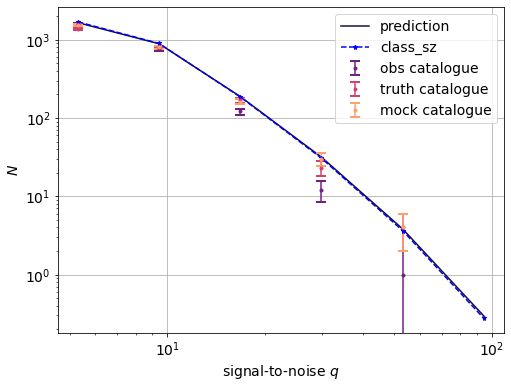

In [27]:
plt.figure(figsize=(8,6))
plt.plot(q, Nq, color=color_list[0], label='prediction')
plt.errorbar(q, catNq, yerr=np.sqrt(catNq), color=color_list[4], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='obs catalogue')
plt.errorbar(q, Nq_truth, yerr=np.sqrt(Nq_truth), color=color_list[8], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='truth catalogue')
plt.errorbar(q, Nq_mock, yerr=np.sqrt(Nq_mock), color=color_list[12], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='mock catalogue')

plt.plot(10**np.asarray(log10y_center[:-1]),N_clusters_y_theory[:-1],
             marker='*',markersize=5.,ls='--',label='class_sz',c='blue')
plt.xlabel('signal-to-noise $q$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
# plt.title('WebSkyHalos A10tSZ cat comparison', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

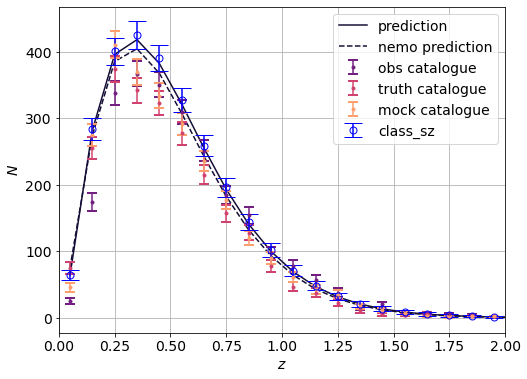

In [28]:
plt.figure(figsize=(8,6))
plt.plot(z, Nz, color=color_list[0], label='prediction')
plt.plot(z, predNz, color=color_list[0], linestyle='--', label='nemo prediction')
plt.errorbar(z, catNz, yerr=np.sqrt(catNz), color=color_list[4], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='obs catalogue')
plt.errorbar(z, Nz_truth, yerr=np.sqrt(Nz_truth), color=color_list[8], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='truth catalogue')
plt.errorbar(z, Nz_mock, yerr=np.sqrt(Nz_mock), color=color_list[12], fmt='o', ms=3, capsize=5, \
             capthick=2, ls='none', label='mock catalogue')

plt.errorbar(z_center,N_clusters_z_theory,yerr=np.sqrt(N_clusters_z_theory),marker='o',markersize=7.,ls='none',
             label='class_sz',capsize=9,
             markerfacecolor='none',
             c='blue')

plt.xlabel('$z$', fontsize=14)
plt.ylabel('$N$', fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
# plt.title('WebSkyHalos A10tSZ cat comparison', fontsize=14)
plt.xlim(0, 2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

# ACT update 8/9/2022

In [29]:
data_dict =  {'data_path': path2data,
         'cat_file': "DR5_cluster-catalog_v1.1.fits",
         'Q_file': "DR5ClusterSearch/selFn/QFit.fits",
         'tile_file': "DR5ClusterSearch/selFn/tileAreas.txt",
         'rms_file': "DR5ClusterSearch/selFn/RMSTab.fits",
         'rms_map': 'DR5ClusterSearch/selFn/stitched_RMSMap_Arnaud_M2e14_z0p4.fits'
             }

In [30]:
data_directory = data_dict['data_path']

datafile_rms = data_dict['rms_file']
list = fits.open(os.path.join(data_directory, datafile_rms))
file_rms = list[1].data


In [31]:
file_rms.columns

ColDefs(
    name = 'areaDeg2'; format = 'D'
    name = 'y0RMS'; format = 'D'
    name = 'tileName'; format = '7A'
)

In [32]:
rms_map = hp.read_map(os.path.join(data_directory,  data_dict['rms_map']))

[healpy] No NSIDE in the header file : will use length of array


AttributeError: 'numpy.ndarray' object has no attribute 'field'

In [ ]:
# example to show a map:
# hp.mollview(log10tsz_map)


# hp.projscatter(planck_like_websky_simple["lon"],
#                planck_like_websky_simple["lat"],
#                s=10,
#                color="white",
#                marker=".",
#                lonlat=True)
# plt.title('simple_ym')
# plt.savefig('simpleym.pdf')

In [122]:
data_directory = data_dict['data_path']
datafile = data_dict['cat_file']
data_directory = data_dict['data_path']
catf = fits.open(os.path.join(data_directory, datafile))
data = catf[1].data
zcat = data.field("redshift")
qcat = data.field("fixed_SNR") #NB note that there are another SNR in the catalogue
cat_snr = data.field("SNR")
cat_tsz_signal = data.field("fixed_y_c")
cat_tsz_signal_err = data.field("fixed_err_y_c")
cat_tile_name = data.field("tileName")

In [123]:
qcat

array([4.63261739, 7.57622615, 4.66106629, ..., 4.23650791, 8.83112077,
       4.88149072])

In [124]:
cat_tsz_signal/cat_tsz_signal_err

array([4.63261739, 7.57622615, 4.66106629, ..., 4.23650791, 8.83112077,
       4.88149072])

In [126]:
cat_snr

array([4.79398688, 7.678747  , 5.6652967 , ..., 4.62351208, 8.92418952,
       5.01499052])

In [59]:
data.columns

ColDefs(
    name = 'name'; format = '19A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'template'; format = '25A'
    name = 'tileName'; format = '7A'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'D'
    name = 'redshiftType'; format = '1000A'
    name = 'redshiftSource'; format = '1000A'
    name = 'M500c'; format = 'D'
    name = 'M500c_errPlus'; format = 'D'
    name = 'M500c_errMinus'; format = 'D'
    name = 'M500cCal'; format = 'D'
    name = 'M500cCal_errPlus'; format = 'D'
    name = 'M500cCal_errMinus'; format = 'D'
    name = 'M200m'; format = 'D'
    name = 'M200m_errPlus'; format = 'D'
    name = 'M200m_errMinus'; format = 'D'
    name = 'M500cUncorr'; format = 'D'
    name = 'M500cUncorr_errPlus'; format =

In [60]:
qcut = 6

ind = np.where(qcat >= qcut)[0]
snr = qcat[ind]

z_cat = zcat[ind]
cat_tsz_signal = cat_tsz_signal[ind]
cat_tsz_signal_err = cat_tsz_signal_err[ind]
cat_tile_name = cat_tile_name[ind]


df = pd.DataFrame(
    {
        "z": z_cat.byteswap().newbyteorder(),#both.survey.clst_z.byteswap().newbyteorder(),
        "tsz_signal": cat_tsz_signal.byteswap().newbyteorder(), #both.survey.clst_y0.byteswap().newbyteorder(),
        "tsz_signal_err": cat_tsz_signal_err.byteswap().newbyteorder(),#survey.clst_y0err.byteswap().newbyteorder(),
        "tile_name": cat_tile_name.byteswap().newbyteorder()#survey.clst_y0err.byteswap().newbyteorder(),

    }
)


In [112]:
binning ={
  # redshift bins for number counts
  'z':
    {'zmin': 0.,
    'zmax': 2.8,
    'dz': 0.1},
  # SNR bins for number counts
  'q':
    {'log10qmin': 0.6,
    'log10qmax': 2.0,
    'dlog10q': 0.1}
}

In [113]:
zbins = np.arange(binning['z']['zmin'], binning['z']['zmax'] + binning['z']['dz'], binning['z']['dz'])
zarr = 0.5*(zbins[:-1] + zbins[1:])
logqmin = binning['q']['log10qmin']
logqmax = binning['q']['log10qmax']
dlogq = binning['q']['dlog10q']
qbins = np.arange(logqmin, logqmax+dlogq, dlogq)
qarr = 10**(0.5*(qbins[:-1] + qbins[1:]))
delN2Dcat,zedges, qedges = np.histogram2d(z_cat, snr, bins=[zbins, 10**qbins])

In [114]:
zedges

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8])

In [115]:
catNq = np.zeros(len(qarr))
for i in range(len(qarr)): 
    catNq[i] = delN2Dcat[:,i].sum()

In [116]:
catNz = np.zeros(len(zarr))
for i in range(len(zarr)):
    catNz[i] = delN2Dcat[i, :].sum()

In [117]:
delN2Dcat

array([[ 0.,  3.,  3.,  1.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.],
       [ 0., 10., 25., 15.,  5.,  2.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.],
       [ 0., 11., 49., 33., 30.,  7.,  5.,  9.,  2.,  1.,  0.,  0.,  0.,
         0.],
       [ 0., 21., 79., 34., 26., 13.,  6.,  4.,  2.,  0.,  0.,  1.,  0.,
         0.],
       [ 0., 30., 82., 48., 22., 13., 14.,  3.,  2.,  0.,  0.,  0.,  0.,
         0.],
       [ 0., 26., 76., 52., 24., 13.,  8.,  2.,  0.,  0.,  1.,  0.,  0.,
         0.],
       [ 0., 21., 62., 43., 23., 16.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.],
       [ 0., 12., 51., 32., 15.,  5.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0., 11., 48., 23.,  6.,  8.,  4.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.],
       [ 0.,  5., 24., 14., 10.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  2., 12., 12.,  2.,  6.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  3.,  5.,  5.,  2.,  2.,  2., 

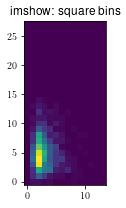

In [118]:
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
H = delN2Dcat
xedges = zedges
yedges = qedges
plt.imshow(H, interpolation='nearest', origin='lower')
       # extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

[matplotlib.legend] *WARNING* No handles with labels found to put in legend.


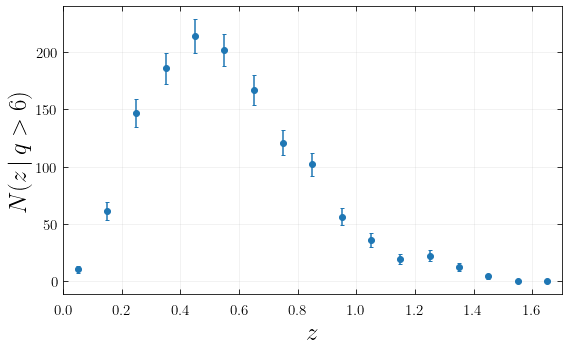

In [119]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(zarr,catNz,yerr=np.sqrt(catNz),ls='None',marker='o',capsize=2)
plt.xscale('linear')
plt.yscale('linear')

plt.legend(frameon=False,fontsize=23,loc=3)
plt.grid(which='both',alpha=0.2)
label_size =15
plt.xlim(0,1.7)
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
plt.xlabel(r'$z$',size=25)
plt.ylabel(r'$N(z\,|\,q>6)$',size=25)
fig.tight_layout()
plt.savefig('nz_dr5.jpeg')

[matplotlib.legend] *WARNING* No handles with labels found to put in legend.


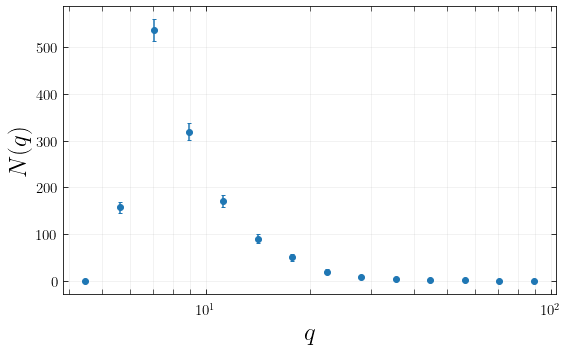

In [121]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(qarr,catNq,yerr=np.sqrt(catNq),ls='None',marker='o',capsize=2)
plt.xscale('log')
plt.yscale('linear')

plt.legend(frameon=False,fontsize=23,loc=3)
plt.grid(which='both',alpha=0.2)
label_size =15
# plt.xlim(0,1.7)
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
plt.xlabel(r'$q$',size=25)
plt.ylabel(r'$N(q)$',size=25)
fig.tight_layout()
plt.savefig('nq_dr5.jpeg')

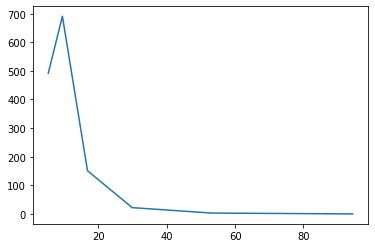

In [85]:
plt.plot(qarr,catNq)

In [53]:
for z in zcat:
    print(z)

0.30059880018234253
0.8781313300132751
0.28257
0.3562180697917938
0.4388004
0.2017347
0.4227475
0.4892
0.551449235072533
0.7019000053405762
0.3464
0.2471434084836339
0.9063078165054321
0.7832745313644409
0.7034
0.8827255964279175
0.19926051432974978
1.149999976158142
0.8380722
0.9677561
0.6320648789405823
0.9615412354469299
0.7674899697303772
0.7198324203491211
0.2333691
0.8911206722259521
0.6426761746406555
0.3693166537221611
0.0924
0.7518452405929565
1.3052
0.2847015857696533
0.8492301106452942
0.979202389717102
0.5252895951271057
0.6087420582771301
0.5488450736706649
0.8397049
0.503
0.114412
0.8279125690460205
0.6182134
0.16724510715493235
0.682
0.544821893196235
0.48037609457969666
0.32857
0.2448449581861496
0.5098081
0.5377047947798087
0.365953461618953
0.5606
0.46
0.753
0.6240959
0.6738360524177551
0.597257137298584
0.23819618584025382
0.9153389930725098
0.7646
0.2771424949169159
0.9686
0.2639677461886653
0.7864671945571899
0.8277
0.2162293642759323
0.741033673286438
0.378
0.5597

0.4609082043170929
0.41176921129226685
0.6427891850471497
0.2766457796096802
0.2846546471118927
0.740397036075592
0.9788000000000001
0.6732088923454285
1.2644
0.9788000000000001
0.9431725740432739
0.9074
0.8540592789649963
0.6093999743461609
0.46000000834465027
0.32668352127075195
0.0369
0.5025039911270142
0.483379989862442
0.5469698309898376
0.4948621392250061
0.274399995803833
0.9380000000000001
0.5198
0.9242227673530579
1.4010000228881836
0.6359924077987671
0.8702703714370728
0.4391079246997833
0.27
0.38999998569488525
0.10339286178350449
0.6406000256538391
0.5144599676132202
0.5766057372093201
0.8093382120132446
0.6719256043434143
0.9718
0.7161611318588257
0.5197646021842957
0.152
0.6837000250816345
1.0196
0.3840799927711487
0.3912743628025055
0.8134797811508179
0.4570908546447754
0.42511147260665894
0.6637212038040161
0.4192872643470764
0.707004725933075
0.17599999904632568
0.4688
0.35179999470710754
0.20260000228881836
0.4075999855995178
0.22599999606609344
1.315999984741211
0.51

0.6974945
0.32946232259443736
0.7566344
0.5504
0.25
0.632
0.3292999863624573
0.4690403342247009
0.554106
0.6728000000000001
0.3616741895675659
0.28450000286102295
0.71
0.632
0.1931705
0.3464
0.2577965
0.7136
0.4178
0.4688
0.6582679
0.4578000009059906
0.5402
0.5606
0.6147000193595886
0.4994
0.9992000000000001
0.42800000000000005
0.1647
0.1938
0.3628000020980835
0.5402
0.3668
0.5708000000000001
0.4688
0.479
0.4178
0.2636
0.798
0.352
0.237
0.3158
0.5810000000000001
0.8336350321769714
0.21191106736660004
0.7349916100502014
0.4828174114227295
0.3171
0.7607561945915222
0.6852145195007324
1.0640000104904175
0.2786000072956085
0.14959999918937683
0.22711551189422607
0.5223028063774109
0.0551999993622303
0.1612
0.5808409452438354
0.23000000417232513
0.35679998993873596
0.1899999976158142
0.23199999332427979
0.26480000000000004
0.5687605738639832
0.5016171932220459
0.3
0.23046623170375824
0.55
0.25452253222465515
0.983640193939209
0.23409999907016754
0.8564
0.6948086023330688
0.2540000081062317


In [ ]:


plt.figure()
ax = df.plot(kind="scatter",x="M200m_websky",y="M500c_websky",c="redshift", cmap='jet',marker=1, sharex=False)

plt.loglog()
plt.tight_layout()